# Model Comparison

Let's reconsider the line-fitting exercise. 

Calgary's population does show a constant increase over time, but only on the surface level. If we look more closely, the earliest and latest time periods are under-estimated by a straight-line fit, while the middle is over-estimated. The population growth appears to follow a curve.

Our first guess for an appropriate curve is exponential. Natural populations usually show exponential growth if unconstrained, after all. One obvious problem is that Calgary's population has plenty of constraints on it, such as the strength of the local economy and the physical space available for expansion. Perhaps a better approach would be to just apply a quadratic curve; yes, that choice is arbitrary, but so too was the choice of using a straight line. A third guess is to invoke splines to model growth. That last one might seem to be a clear winner by a wide margin, thanks to overfitting, but remember that priors are typically assigned before we observe the data.

For your part, implement at least two models to describe Calgary's growth. One of those can be linear growth, provided you reparameterize the line to remove the intercept parameter.

A bigger problem is deciding on an appropriate comparison metric. Use one of these:

First, $p(E|H)p(H)$. This is the ideal metric to use, though it comes with some caveats. Stan calculates this value for you and stores it in the `__lp` parameter, however Stan saves some CPU cycles by dropping constant terms. This has no effect on intra-model comparisons, but ruins your ability to compare models with differing constants. Either manually correct that value by restoring constant terms, or take advantage of Stan's built-in functions to calculate those values for you. Another caveat is that we're sampling from the posterior, so at minimum try multiple random seeds to guage if one run is an outlier.

Second, the Bayesian Information Criterion (BIC). If the posterior sample has converged on the final distribution, and there is sufficient data, then that distribution is well-approximated by the maximal likelihood. If so, we can define the following metric:

\begin{align}
\text{BIC} = |\vec \theta| \ln |E| - 2 \ln p( E | \hat \theta )p(\hat \theta)
\end{align}

where $\vec \theta$ is a vector of parameters used by the model in question, $E$ are the datapoints used to fit the model, and $\hat \theta$ is the parameter vector with the maximal likelihood. While it is tempting to use the maximal likelihood of the posterior as the global maximal likelihood, Stan also has [some optimization algorithms built-in](https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.optimize) which can be more efficient. A common pattern is to combine both, sampling from the posterior to "feel out" the parameter space's global maximum then using the maximal likelihood from the posterior as a starting point for the optimization algorithms.

# Imports

In [1]:
import arviz as az
from cmdstanpy import install_cmdstan, CmdStanModel

import matplotlib.pyplot as plt
import numpy as np
from os import mkdir
from os.path import exists, isdir

import pandas as pd
import scipy as sp
from tqdm import tqdm as tqdm

In [2]:
# This can take a few minutes, so consider running it now then tabbing back
install_cmdstan()

Installing CmdStan version: 2.32.2
Install directory: /home/hjhornbeck/.cmdstan
CmdStan version 2.32.2 already installed


True

# Global Variables / Methods

In [3]:
data_file  = 'data/calgary_population.csv.bz2'
model_file = 'models/model_comparison.stan'

# create some useful directories
for directory in ['data','derived','models','posteriors']:
    if not isdir(directory):
        mkdir(directory)

rng = np.random.default_rng(42)

# Data

In [4]:
# if it hasn't been cached, download it!
if not exists( data_file ):
    
    dataset = pd.read_csv( 'https://data.calgary.ca/api/views/rmai-qvzh/rows.csv?accessType=DOWNLOAD' )
    dataset.to_csv( data_file, index=False )

dataset = pd.read_csv( data_file )
cleaned = dataset.drop( ['Ward','Vehicles','Age 65 +','Voters','CENSUS_YEAR'], axis=1 \
                      ).groupby(['Year']).sum().reset_index()

cleaned

Year  Dwellings  Residents
0   1958    64288.0     206831
1   1959        0.0     218418
2   1960    72987.0     235428
3   1961        0.0     241673
4   1962    81610.0     269068
..   ...        ...        ...
57  2015   492623.0    1230915
58  2016   499222.0    1235171
59  2017   506392.0    1246337
60  2018   515391.0    1267344
61  2019   521257.0    1285711

[62 rows x 3 columns]

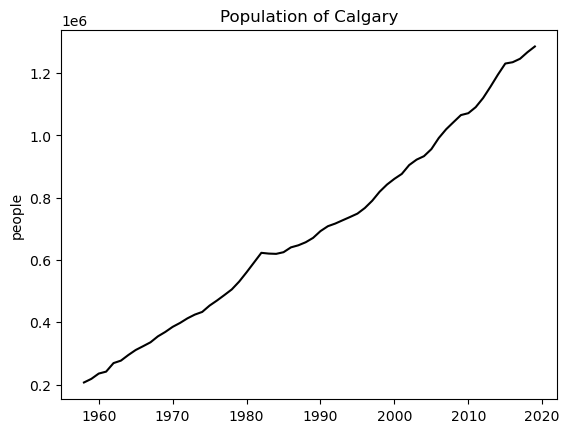

In [5]:
plt.plot( cleaned.Year, cleaned.Residents, '-k', label='data')
plt.title("Population of Calgary")
plt.ylabel('people')
plt.show()

# Model

In [ ]:
stan_code = '''
data {
  int n;       // number of datapoints
  vector[n] X; // the X and Y values of those datapoints
  vector[n] Y;
}
parameters {
  real m;              // slope
  real<lower=0> sigma; // standard deviation
}
model {
    /* TODO */
}
'''

with open(model_file,'wt') as file:
  file.write(stan_code)

In [ ]:
model = CmdStanModel(stan_file=model_file, cpp_options={'STAN_THREADS': 'TRUE'})

In [ ]:
data = {'n':len(cleaned), 'X':list(cleaned.Year), 'Y':list(cleaned.Residents)} # must be serializable!

# Sampling

In [ ]:
fit = model.sample( data=data )

# Diagnostics

In [ ]:
print( fit.diagnose() );

In [ ]:
fit.summary()

In [ ]:
az.plot_trace( fit );
plt.tight_layout()

In [ ]:
az.plot_pair( fit, marginals=True, point_estimate="median" );
plt.tight_layout()

# Results